## Creating a GIF of water level change at Lake Cachuma

### About

Lake Cachuma was once a primary water source for Santa Barbara County, but the California drought has made it an unreliable resevoir.In 2017, the reservoir was part of the 2.13% of California that was considered to be in an "exceptional drought".Given that this resevoir is the majority water source for over 200,000 Santa Barbara residents, the water levels in the Cachuma have a major impact on its residents. While the drought is not over, heavy rains in 2022 - 2023 helped Lake Cachuma reach it's capacity for the first time in 11 years. 


![](images/lake_cachuma_levels.jpeg)


### Purpose

We will use satelittle imagery to see if we can notice changes in water levels when the reservoir was at an all time low versus being at capacity. We will be specifically looking at the water levels in Harvey Bay. In order to show the water level change in this 7 year time span, we will create a gif. 

![](images/lake_cachuma_map.png)

### About the data:

To carry out this task, we will use the Microsoft Planetary Computer Catalog. We will be using NAIP imagery from the catalog in the years 2016 to 2023. 

#### Load libraries and data

First, lets load our libraries. To create the GIF we’ll be using the [geogif](https://geogif.readthedocs.io/en/latest/) library, which makes it simple to create gifs from `xarray.DataArrays`.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import rioxarray as rioxr
from pystac_client import Client  # To access STAC catalogs
import planetary_computer  # To sign items from the MPC STAC catalog 
from IPython.display import Image  # To nicely display images
from geogif import gif
from shapely.geometry import box
import xarray as xr

Next we will access our data via the MPC catalog. Access the naip collection and store the collection in `naip_collection`.

In [2]:
# Access MPC catalog
catalog = Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)


catalog.get_collections()
collections = list(catalog.get_collections())  # Turn generator into list

print('Number of collections:', len(collections))

print("Collections IDs (first 10):")

for i in range(10):
    print('-', collections[i].id)
    
    
naip_collection = catalog.get_child('naip')
naip_collection

Number of collections: 124
Collections IDs (first 10):
- daymet-annual-pr
- daymet-daily-hi
- 3dep-seamless
- 3dep-lidar-dsm
- fia
- sentinel-1-rtc
- gridmet
- daymet-annual-na
- daymet-monthly-na
- daymet-annual-hi


<CollectionClient id=naip>

Now that we have our data, we need to specify the temporal and spatial information we are interested in. Specify the range of interest in the `time_range` variable. We are intersted at the time when Lake Cachuma was at its lowest (01/01/2016) until the heavy rain storms (01/01/2023). 

We will use the geojson.io tool in order to easily get our bounding box. Head to this [link](https://geojson.io/#new&map=11.22/34.5894/-119.9182) and either use the rectangle tool to draw a bounding box around Harvey Bay or insert four different points. Look at the coordinates on each point and instead them in the`bbox` variable in the following order: [minx, miny, maxx, maxy]. 

In [22]:
# Temporal range of interest during drought
time_range = "2016-01-01/2023-01-01"


bbox = [-119.96097881624155, 34.59355560156439, -119.95285863324072, 34.601656671761646]


Now that we specificed our bounding box and time range, lets do a catalog search to get our data. Be sure to include your `bbox` and `time_range` in your search. After completing your search, retrieve your search items and assign the first item in your catalog search to the variable `item`. 

In [23]:
# Catalog search
# search 
search = catalog.search(
    collections=["naip"], 
    bbox=bbox, 
    datetime='2016/2023'
)

# get items from search
items = search.item_collection()
print(f'There are {len(items)} items in the search.')

There are 4 items in the search.


In [24]:
# Get first item in the catalog search
item = items[0]
type(item)

pystac.item.Item

#### Let's look at a single raster. 

The NAIP data is available at the item’s 'image' asset. Use `rioxr.open_rasterio` to open the image asset. 



In [25]:
lake_levels = rioxr.open_rasterio(item.assets['image'].href)
lake_levels


<xarray.DataArray (band: 4, y: 12510, x: 10570)> Size: 529MB
[528922800 values with dtype=uint8]
Coordinates:
  * band         (band) int64 32B 1 2 3 4
  * x            (x) float64 85kB 2.246e+05 2.246e+05 ... 2.309e+05 2.309e+05
  * y            (y) float64 100kB 3.836e+06 3.836e+06 ... 3.828e+06 3.828e+06
    spatial_ref  int64 8B 0
Attributes:
    TIFFTAG_IMAGEDESCRIPTION:  OrthoVista
    TIFFTAG_SOFTWARE:          Trimble Germany GmbH
    TIFFTAG_XRESOLUTION:       1
    TIFFTAG_YRESOLUTION:       1
    TIFFTAG_RESOLUTIONUNIT:    1 (unitless)
    AREA_OR_POINT:             Area
    _FillValue:                0
    scale_factor:              1.0
    add_offset:                0.0

This rater is way bigger than our area of interest. To verify this and then clip the raster, let’s make a gpd.GeoDataFrame from the bbox coordinates:

This rater is way bigger than our area of interest. To verify this and then clip the raster,make a gpd.GeoDataFrame from the bbox coordinates:



In [26]:
# bounding box as geodataframe
box_df = gpd.GeoDataFrame(geometry=[box(*bbox)],
                 crs='epsg:4326') 

In [27]:
# clip raster to bounding box
lake_levels = lake_levels.rio.clip_box(*box_df.to_crs(lake_levels.rio.crs).total_bounds)

NAIP data has four bands, Red, Green, Blue, and Near-Infrared. To make it easier to plot RGB images, select only the first three bands.

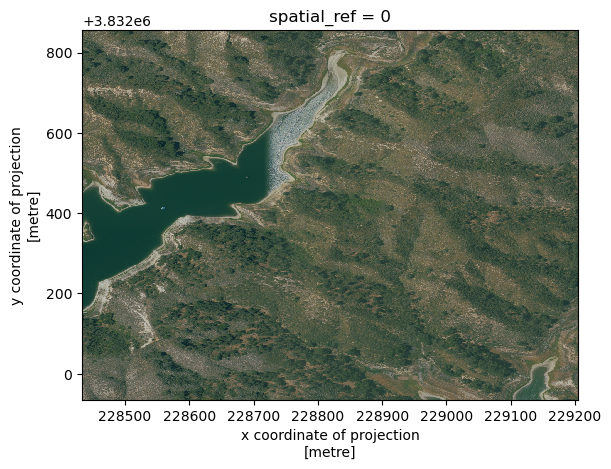

In [28]:
lake_levels = lake_levels.sel(band=[1,2,3])
lake_levels.plot.imshow()

#### Stack Rasters

Our goal is to use the gif function to create a gif with the four NAIP images over Lake Cachuma.

The gif documentation indicates that to do so we will need to put our images/rasters in a single `xarray.DataArray` with dimensions (time, band, y, x). Check your raster to see what the dimmensions are. 

In [29]:
# Check raster dimensions
lake_levels.dims

# Check the shape of the raster
lake_levels.shape

(3, 1535, 1286)

To create a single xarray.DataArray with a time dimensions we will stack the four rasters we obtained in our search. We use a for loop to repeat the previous steps for each item in the search (access the item’s image asset, clip, and select bands) and store each processed raster in a list `rasters`.

In [30]:
rasters = []
for item in items: 
    lake_levels = rioxr.open_rasterio(item.assets['image'].href)
    lake_levels = lake_levels.sel(band=[1,2,3])
    rasters.append(lake_levels)

Next lets use the `xarray.concat()` function to concatenate these rasters along a new dimensions we will call `time`. 

In [ ]:
# concatenate rasters into single xarray.DataArray
stack = xr.concat(rasters, dim='time')
stack

Notice our new dimension `time` does not have any coordinates associated to it. To add coordinates to this dimensions we use the `assign_coords()`  method for `xarray.DataArray`.

It would be reasonable to use the year of collection of each raster (as a timestamp) as its coordinate on the time dimension. We can see this year in the item’s properties:

In [ ]:
# year of collection of an item 
item = items[0]
item.properties['naip:year']

In [ ]:
# convert strings to datetime
pd.to_datetime(item.properties['naip:year'])

To get this timestamp for each year we can create a list using list comprehension:



In [17]:
times = [pd.to_datetime(item.properties['naip:year']) for item in items]
times

[Timestamp('2022-01-01 00:00:00'),
 Timestamp('2020-01-01 00:00:00'),
 Timestamp('2018-01-01 00:00:00'),
 Timestamp('2016-01-01 00:00:00')]

And finally we assign these times as the coordinates (using `assign_coords()`) and sort by the vlaues of time dimension:



In [18]:
stack = stack.assign_coords(time=times).sortby("time")
stack

<xarray.DataArray (time: 4, band: 3, y: 12510, x: 10570)> Size: 6GB
array([[[[ nan,  nan,  nan, ...,  nan,  nan,  nan],
         [ nan,  nan,  nan, ...,  nan,  nan,  nan],
         [ nan,  nan,  nan, ...,  nan,  nan,  nan],
         ...,
         [ nan,  nan,  nan, ...,  nan,  nan,  nan],
         [ nan,  nan,  nan, ...,  nan,  nan,  nan],
         [ nan,  nan,  nan, ...,  nan,  nan,  nan]],

        [[ nan,  nan,  nan, ...,  nan,  nan,  nan],
         [ nan,  nan,  nan, ...,  nan,  nan,  nan],
         [ nan,  nan,  nan, ...,  nan,  nan,  nan],
         ...,
         [ nan,  nan,  nan, ...,  nan,  nan,  nan],
         [ nan,  nan,  nan, ...,  nan,  nan,  nan],
         [ nan,  nan,  nan, ...,  nan,  nan,  nan]],

        [[ nan,  nan,  nan, ...,  nan,  nan,  nan],
         [ nan,  nan,  nan, ...,  nan,  nan,  nan],
         [ nan,  nan,  nan, ...,  nan,  nan,  nan],
         ...,
...
         ...,
         [124., 126., 129., ..., 117., 122., 121.],
         [126., 127., 131., ..., 113., 112., 115.],
         [130., 129., 131., ...,  96., 100., 108.]],

        [[ 54.,  54.,  47., ..., 134., 136., 134.],
         [ 56.,  54.,  48., ..., 110., 142., 142.],
         [ 55.,  58.,  58., ...,  91., 129., 145.],
         ...,
         [115., 116., 119., ..., 110., 115., 112.],
         [118., 118., 120., ..., 110., 109., 110.],
         [119., 120., 120., ...,  99., 100., 105.]],

        [[ 50.,  50.,  44., ..., 103., 107., 103.],
         [ 51.,  50.,  43., ...,  87., 110., 112.],
         [ 46.,  51.,  50., ...,  71.,  98., 114.],
         ...,
         [ 99.,  99., 100., ..., 104., 106., 102.],
         [ 99., 100., 101., ..., 106., 104., 101.],
         [ 99., 101., 101., ...,  93.,  94.,  96.]]]], dtype=float32)
Coordinates:
  * band         (band) int64 24B 1 2 3
  * x            (x) float64 85kB 2.246e+05 2.246e+05 ... 2.309e+05 2.309e+05
  * y            (y) float64 100kB 3.828e+06 3.828e+06 ... 3.836e+06 3.836e+06
    spatial_ref  int64 8B 0
  * time         (time) datetime64[ns] 32B 2016-01-01 2018-01-01 ... 2022-01-01
Attributes:
    TIFFTAG_IMAGEDESCRIPTION:  OrthoVista
    TIFFTAG_SOFTWARE:          Trimble Germany GmbH
    TIFFTAG_XRESOLUTION:       1
    TIFFTAG_YRESOLUTION:       1
    TIFFTAG_RESOLUTIONUNIT:    1 (unitless)
    AREA_OR_POINT:             Area
    _FillValue:                0
    scale_factor:              1.0
    add_offset:                0.0

#### Now its  time to make a GIF! 

Use the gif function to create a gif of our stacked raster. Look at the documentation for `gif()`. What does the fps parameter stnad for? 


In [ ]:
# create gif
# fps = frames per second
# adding to="campus_point.gif" will save GIF
gif(stack, fps = 0.5)

/opt/anaconda3/envs/eds220-env/lib/python3.11/site-packages/geogif/gif.py:255: RuntimeWarning: invalid value encountered in cast
  u8 = (data * 255).astype("uint8")
/opt/anaconda3/envs/eds220-env/lib/python3.11/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (130390700 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/opt/anaconda3/envs/eds220-env/lib/python3.11/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (132230700 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


### References

Santa Maria Times. "Cachuma Lake Among the Last of State's Reservoirs in Exceptional Drought." Santa Maria Times. January 26, 2017. https://santamariatimes.com/news/local/cachuma-lake-among-the-last-of-states-reservoirs-in-exceptional-drought/article_e358ca8e-654d-5ff7-9b58-857914a4ccd4.html.

The Santa Barbara Independent. "Cachuma Fills and Flood Gates to Open." The Santa Barbara Independent, January 14, 2023. https://www.independent.com/2023/01/14/cachuma-fills-and-flood-gates-to-open/.